# Aplaying Floyd Warshall

In [1]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import shapely
from matplotlib.patches import Circle
from shapely import Polygon
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
%matplotlib inline
import plotly.graph_objects as go

Text(2.5, 5.0, 'Start')

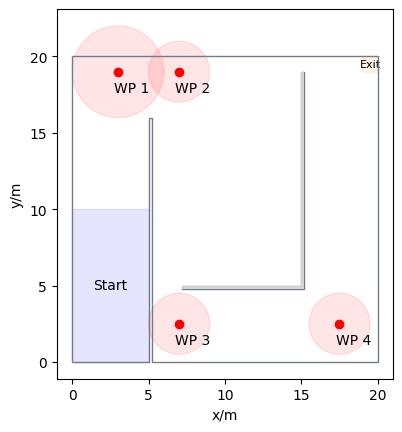

In [2]:
complete_area = Polygon(
    [
        (0, 0),
        (0, 20),
        (20, 20),
        (20, 0),
    ]
)
obstacles = [
    Polygon(
        [
            (5, 0.0),
            (5, 16),
            (5.2, 16),
            (5.2, 0.0),
        ]
    ),
    Polygon([(15, 19), (15, 5), (7.2, 5), (7.2, 4.8), (15.2, 4.8), (15.2, 19)]),
]

exit_polygon = [(19, 19), (20, 19), (20, 20), (19, 20)]
waypoints = [([3, 19], 3), ([7, 19], 2), ([7, 2.5], 2), ([17.5, 2.5], 2)]
distribution_polygon = Polygon([[0, 0], [5, 0], [5, 10], [0, 10]])
obstacle = shapely.union_all(obstacles)  # combines obstacle polygons into only one polygon
walkable_area = pedpy.WalkableArea(
    shapely.difference(complete_area, obstacle))  # difference subtracts obstacle form complete_area
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in enumerate(waypoints):
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"WP {idx + 1}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(10, -15),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)

x, y = Polygon(exit_polygon).exterior.xy
plt.fill(x, y, alpha=0.1, color="orange")
centroid = Polygon(exit_polygon).centroid
plt.text(centroid.x, centroid.y, "Exit", ha="center", va="center", fontsize=8)

x, y = distribution_polygon.exterior.xy
plt.fill(x, y, alpha=0.1, color="blue")
centroid = distribution_polygon.centroid
plt.text(centroid.x, centroid.y, "Start", ha="center", va="center", fontsize=10)

## Configuration of Simulation Scenarios

In [3]:
simulations = {}
percentages = [0, 20, 40, 50, 60, 70, 100]
total_agents = 100
for percentage in percentages:
    trajectory_file = f"../../sqlite_data/floyd_warshall_percentage_{percentage}.sqlite"
    simulation = jps.Simulation(
        dt=0.05,
        model=jps.CollisionFreeSpeedModel(
            strength_neighbor_repulsion=2.6,
            range_neighbor_repulsion=0.1,
            range_geometry_repulsion=0.05,
        ),
        geometry=walkable_area.polygon,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file),
        ),
    )
    simulations[percentage] = simulation

## Choosing the path
### Floyd Warshall

In [4]:
def floyd_warshall_path(graph):
    n = len(graph)

    # Inicializamos las matrices de distancias y predecesores
    dist = [[float('inf')] * n for _ in range(n)]
    next_node = [[-1] * n for _ in range(n)]

    # Configuramos las matrices iniciales
    for i in range(n):
        for j in range(n):
            if i == j:
                dist[i][j] = 0
            elif graph[i][j] != 0:
                dist[i][j] = graph[i][j]
                next_node[i][j] = j  # Nodo siguiente en el camino más corto

    # Aplicamos el algoritmo de Floyd-Warshall
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    next_node[i][j] = next_node[i][k]

    return dist, next_node

# Función para reconstruir el camino
def get_path(next_node, start, end):
    if next_node[start][end] == -1:
        return None  # No hay camino

    path = [start]
    while start != end:
        start = next_node[start][end]
        path.append(start)

    return path

In [5]:
inf = float('inf')
graph = [
    [0, 2, inf, inf, inf, inf], # start -> 0
    [inf, 0, 1, 6, inf, inf], # WP1 -> 1
    [inf, inf, 0, 4, inf, 3], # WP2 -> 2
    [inf, inf, inf, 0, 3, inf], # WP3 -> 3
    [inf, inf, inf, inf, 0, 4], # WP4 -> 4
    [inf, inf, inf, inf, inf, 0] # Exit -> 5
]

graph2 = [  # removing the connection from WP2 to Exit
    [0, 2, inf, inf, inf, inf], # start -> 0
    [inf, 0, 1, 6, inf, inf], # WP1 -> 1
    [inf, inf, 0, 4, inf, inf], # WP2 -> 2
    [inf, inf, inf, 0, 3, inf], # WP3 -> 3
    [inf, inf, inf, inf, 0, 4], # WP4 -> 4
    [inf, inf, inf, inf, inf, 0] # Exit -> 5
]

dist, next_node = floyd_warshall_path(graph)
dist2, next_node2 = floyd_warshall_path(graph2)

In [6]:
# See How it works
start, end = 0,5
path = get_path(next_node2, start, end)

# Mostramos resultados
print("Matriz de distancias:")
for row in dist2:
    print(row)

print(f"\nCamino más corto de {start} a {end}: {path}")

Matriz de distancias:
[0, 2, 3, 7, 10, 14]
[inf, 0, 1, 5, 8, 12]
[inf, inf, 0, 4, 7, 11]
[inf, inf, inf, 0, 3, 7]
[inf, inf, inf, inf, 0, 4]
[inf, inf, inf, inf, inf, 0]

Camino más corto de 0 a 5: [0, 1, 2, 3, 4, 5]


### Outlining Agent Journeys

In [ ]:
def differentGraphs(start, end, next_node, waypoint_ids, exit_id):
    path = get_path(next_node, start, end)
    needed_waypoint = [waypoint_ids[i-1] for i in path[1:-1]]
    journey = jps.JourneyDescription([*needed_waypoint[:], exit_id])
    for idx, waypoint in enumerate(needed_waypoint):
        next_waypoint = (
            exit_id if idx == len(needed_waypoint) - 1 else needed_waypoint[idx + 1]
        )
        journey.set_transition_for_stage(
            waypoint, jps.Transition.create_fixed_transition(next_waypoint)
        )
    return journey

In [ ]:
def set_journeys(simulation, start, end):
    exit_id = simulation.add_exit_stage(exit_polygon)
    waypoint_ids = []
    for waypoint, distance in waypoints:
        waypoint_ids.append(simulation.add_waypoint_stage(waypoint, distance))

    journey = differentGraphs(start, end, next_node, waypoint_ids, exit_id)
    journey2 = differentGraphs(start, end, next_node2, waypoint_ids, exit_id)

    journey_id = simulation.add_journey(journey)
    journey2_id = simulation.add_journey(journey2)
    return journey_id, journey2_id, waypoint_ids[0]

## Allocation of agents

In [ ]:
positions = jps.distribute_by_number(
    polygon=distribution_polygon,
    number_of_agents=total_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.7,
    seed=45131502,
)

## Launching the Simulation

In [ ]:
trajectory_files = {}
for percentage, simulation in simulations.items():
    journey_id, journey2_id, first_waypoint_id = set_journeys(
        simulation, 0, 5  # 0 -> start, 5 -> exit
    )

    num_items = int(len(positions) * (percentage / 100.0))

    for position in positions[num_items:]: # second half of positions
        simulation.add_agent(
            jps.CollisionFreeSpeedModelAgentParameters(
                position=position,
                journey_id=journey_id,
                stage_id=first_waypoint_id,
            )
        )

    for position in positions[:num_items]: # first half of positions
        simulation.add_agent(
            jps.CollisionFreeSpeedModelAgentParameters(
                position=position,
                journey_id=journey2_id,
                stage_id=first_waypoint_id,
            )
        )

    while simulation.agent_count() > 0 and simulation.iteration_count() < 3000:
        simulation.iterate()

    trajectory_file = f"../../sqlite_data/floyd_warshall_percentage_{percentage}.sqlite"
    trajectory_files[percentage] = trajectory_file

## Visualizing Agent Pahtways

In [ ]:
agent_trajectories = {}
for percentage in percentages:
    trajectory_file = trajectory_files[percentage]
    agent_trajectories[percentage], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[percentage],
        walkable_area,
        title_note=f"Percentage using the shortest path: {percentage}%",
    ).show()